# Managing reliability and computing resources using Genetic Algorithms
Template: Automated design using evolutionary computation

## Anderson Ramos Carneiro
### March 2025
### University of London

## 1. Installation and importing main libraries

In [1]:
# Uncomment the following line to install the required packages
# %pip install -r requirements.txt

In [1]:
import pygad
import logging
import statistics

import matplotlib.pyplot as plt
import numpy as np
import logging
import pandas as pd
import multiprocess as mp # necessary for parallel processing in macos (fork of multiprocessing)
import time
import logging
import os

# from joblib import Parallel, delayed
import psutil

from cloud_simulation.simulation import Simulation
from cloud_simulation.service import SLO, Service, RequestConsumption
from cloud_simulation.scaling import  WeightedPredicateBasedScaling, create_response_time_predicate
from cloud_simulation.traffic import SteadyTraffic, DailyPattern, GradualGrowth

from ga_utils import create_weighted_predicate_scaling_strategy, generate_gene_space
from plotting_utils import plot_traffic_patterns, plot_simulation_results, show_simulation_summary, plot_multi_run_comparison, display_decoded_predicates, create_metric_comparison_tables

from IPython.display import display

# Set logging level to suppress info messages
# Use WARNING to show only warnings, errors and critical messages
# Use ERROR to show only errors and critical messages
# Use CRITICAL to show only critical messages
logging.getLogger().setLevel(logging.ERROR)

## SERVICE CONFIGURATION
BASELINE_LATENCY_SCALE_UP_THRESHOLD = 2
BASELINE_LATENCY_SCALE_DOWN_THRESHOLD = 1.5
SLO_OBJECTIVE = 0.96
SLO_LATENCY_THRESHOLD = BASELINE_LATENCY_SCALE_UP_THRESHOLD * 10

## SIMULATION CONFIGURATION
TOTAL_CYCLES = 240
CPU_CONSUMPTION = 70
RAM_CONSUMPTION = 30
MAX_VMS_TO_SCALE_UP = 5
MAX_VMS_TO_SCALE_DOWN = 2

## GA CONFIGURATION
NUM_GENERATIONS = 30
NUM_PREDICATES = 10
GENES_PER_PREDICATE = 3
SOLUTIONS_PER_POP = 40
INDEX_SCALE_DOWN = (NUM_PREDICATES * GENES_PER_PREDICATE)/2

## GENE SPACE CONFIGURATION
GENE_SPACE = generate_gene_space(BASELINE_LATENCY_SCALE_UP_THRESHOLD, BASELINE_LATENCY_SCALE_DOWN_THRESHOLD, NUM_PREDICATES, GENES_PER_PREDICATE, INDEX_SCALE_DOWN)  


# Define the GA parameters as a dictionary
GA_PARAMS = {
    "num_generations": NUM_GENERATIONS,
    "num_parents_mating": 8,  # More parents = more diversity
    "sol_per_pop": SOLUTIONS_PER_POP,  
    "num_genes": NUM_PREDICATES * GENES_PER_PREDICATE,
    "gene_space": GENE_SPACE,
    "parent_selection_type": "rank",
    # "K_tournament": 3,  # Tournament selection parameter
    "crossover_type": "two_points",
    "crossover_probability": 0.8,  
    "mutation_type": "adaptive",
    "mutation_probability": [0.8, 0.2],  # Start higher, end lower
    "mutation_percent_genes": [30, 10],  # Adaptive mutation percentage
    "keep_elitism": 8,  # Keep best 8 solutions between generations
    "keep_parents": 4,  
    "stop_criteria": ["saturate_8"] #,  # Stop if the best fitness does not change for 8 generations
}


# This is the standard fitness formula, used in the GA to evaluate the fitness of each solution.
def fitness_formula(total_error_budget, min_error_budget, error_budget_distance, avg_response_time, avg_vm_count):        
    if error_budget_distance > total_error_budget:
        # High penalty for exceeding the total error budget
        error_budget_part = -(error_budget_distance * 100)
    elif min_error_budget > 0:
        #THe error budget is not exceeded, very small penalty
        error_budget_part = -(error_budget_distance * 0.1)
    else:
        # Smaller penalty for acceptable distances
        error_budget_part = -(error_budget_distance * total_error_budget)
    
    return error_budget_part - (avg_response_time*0.3) - (avg_vm_count*0.3) #penalty for high response time and high vm count
    

# Service factory function
# This function creates a service instance with the specified parameters.
def service_factory():
    return Service(name="API", 
                      slo=SLO(objective=SLO_OBJECTIVE, threshold=SLO_LATENCY_THRESHOLD, total=TOTAL_CYCLES),
                      request_consumption=RequestConsumption(cpu=CPU_CONSUMPTION, ram=RAM_CONSUMPTION)
                      )


### 1.1 Traffic Patterns

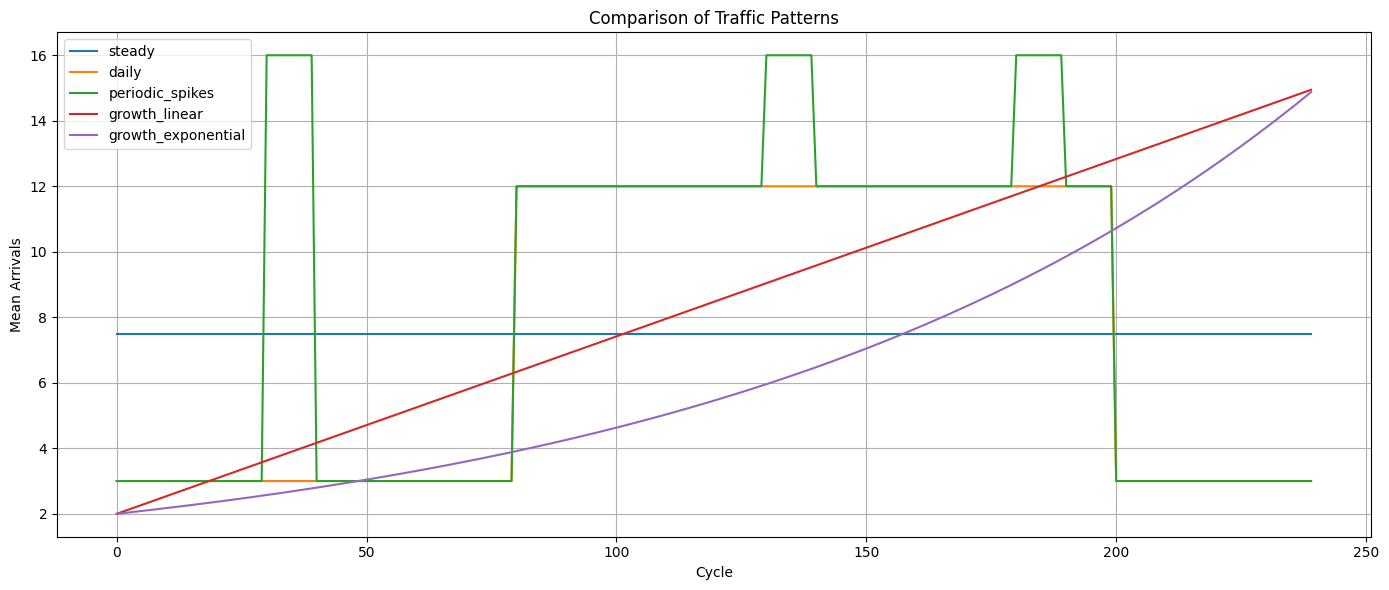

In [2]:

# Define available traffic patterns
traffic_patterns = {
    "steady": SteadyTraffic(mean_arrivals=7.5),
    "daily": DailyPattern(peak_arrivals=12.0, off_peak_arrivals=3.0),
    "periodic_spikes": DailyPattern(peak_arrivals=12.0, off_peak_arrivals=3.0, spike_arrivals=16.0, spike_hours=[3, 13, 18]),
    "growth_linear": GradualGrowth(initial_arrivals=2.0, final_arrivals=15.0, ),
    "growth_exponential": GradualGrowth(initial_arrivals=2.0, final_arrivals=15.0, growth_type="exponential")

}
plot_traffic_patterns(traffic_patterns, total_cycles=TOTAL_CYCLES)

## 2. Exploring Genetic Algorithms and testing Simulation environment

### 2.1 Creating the fitness function, using the formula defined at the top

In [3]:
def fitness_func(ga_instance, solution, solution_idx, traffic_pattern=None, fitness_formula=fitness_formula):
    """
    GA fitness function wrapper for simulation.
    This function will be called by the GA to evaluate the fitness of each solution.
    """
    
    service = service_factory()

    # Create scaling predicates using the fixed predicate decoder
    # scale_up_predicates_with_weights, scale_down_predicates_with_weights = decode_fixed_predicates(solution, genes_per_predicate=GENES_PER_PREDICATE, predicates_per_direction=int(NUM_PREDICATES/2))



    scaling_strategy = create_weighted_predicate_scaling_strategy(solution=solution,
                                                                  genes_per_predicate=GENES_PER_PREDICATE, 
                                                                  num_predicates=NUM_PREDICATES,
                                                                  service=service,
                                                                  max_vms_to_add=MAX_VMS_TO_SCALE_UP, 
                                                                  max_vms_to_remove=MAX_VMS_TO_SCALE_DOWN)
    
    # Run the simulation
    results = Simulation.run_simulation(traffic_pattern, scaling_strategy=scaling_strategy, verbose=False, service=service,  total_cycles=TOTAL_CYCLES)
    
    # Calculate key metrics
    avg_response_time = statistics.mean(results.response_history)
    avg_vm_count = statistics.mean(results.vm_history)
    min_error_budget = min(results.error_budget_history)
    error_budget_distance = abs(min_error_budget)

    # Calculate fitness using the provided formula
    fitness = fitness_formula(service.slo.error_budget, min_error_budget, error_budget_distance, avg_response_time, avg_vm_count)


    return fitness




### 2.2 Running a simulation and ploting the results of the best solution

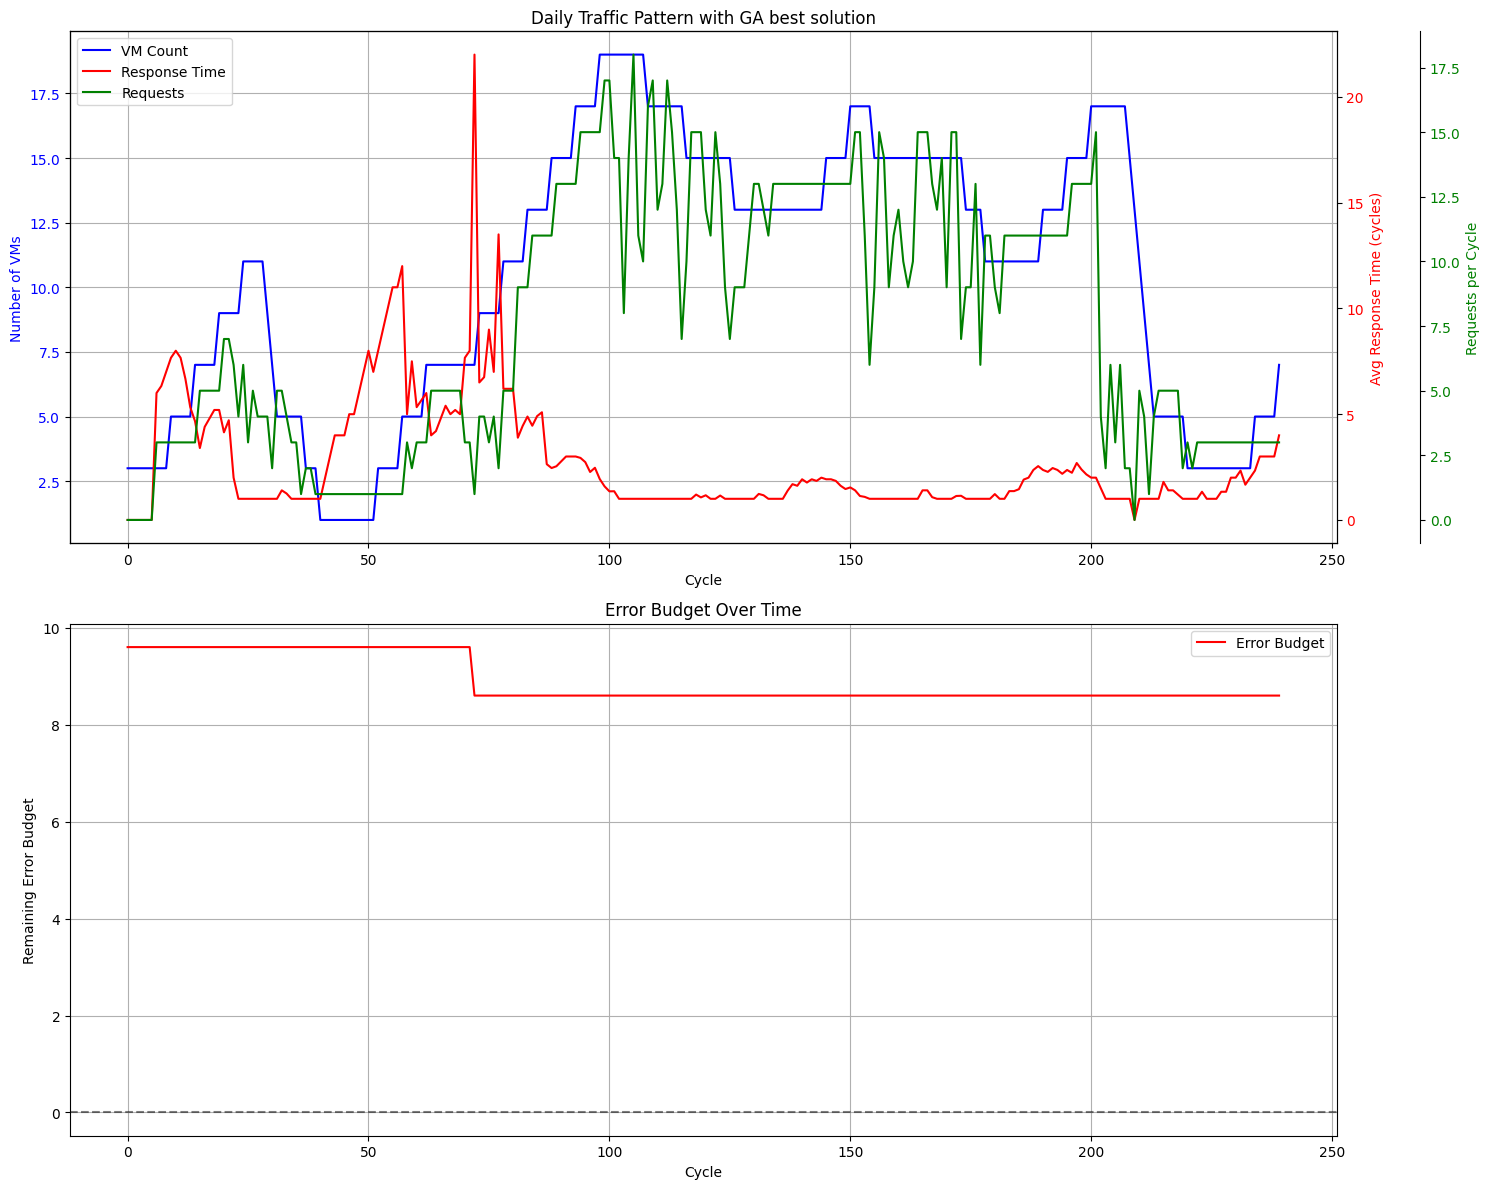

,Direction,Index,Metric,Operator,Threshold,Weight,Genes
0,Scale Up,1,Response Time,>,1.80,5.0,"[2.0, 18.0, 5.0]"
1,Scale Up,2,Response Time,>,5.90,1.0,"[2.0, 59.0, 1.0]"
2,Scale Up,3,CPU Utilization,>,15.00,2.0,"[0.0, 15.0, 2.0]"
3,Scale Up,4,CPU Utilization,<,90.00,2.0,"[1.0, 90.0, 2.0]"
4,Scale Up,5,Queue Length,<,5.40,4.0,"[5.0, 27.0, 4.0]"
5,Scale Down,1,Response Time,<,1.50,4.0,"[3.0, 15.0, 4.0]"
6,Scale Down,2,CPU Utilization,<,41.00,2.0,"[1.0, 41.0, 2.0]"
7,Scale Down,3,Response Time,>,5.60,4.0,"[2.0, 56.0, 4.0]"
8,Scale Down,4,Queue Length,<,15.00,3.0,"[5.0, 75.0, 3.0]"
9,Scale Down,5,Response Time,<,2.40,3.0,"[3.0, 24.0, 3.0]"


In [5]:


logging.getLogger().setLevel(logging.ERROR)

def ga_fitness_function(ga_instance, solution, solution_idx):
    return fitness_func(ga_instance, 
                        solution,
                        solution_idx, 
                        traffic_pattern=traffic_patterns["daily"], 
                        fitness_formula=fitness_formula)  

# Running the GA with basic parameters
ga_instance = pygad.GA(
    **GA_PARAMS,
    fitness_func=ga_fitness_function,
    )



# Run the GA.
ga_instance.run()

# Retrieve and print the best solution.
solution, solution_fitness, solution_idx = ga_instance.best_solution()
logging.info("Best solution (decoded gene vector):", solution)
logging.info("Fitness value:", solution_fitness)

### DECODE THE BEST SOLUTION AND PLOT RESULTS
# Create new service and SLO
sim_service = service_factory()

# this method will decode the best solution into a scaling strategy containing the lists of scaling predicates
scaling_strategy = create_weighted_predicate_scaling_strategy(solution=solution, # encoded best solution
                                                                genes_per_predicate=GENES_PER_PREDICATE, 
                                                                num_predicates=NUM_PREDICATES,
                                                                scale_up_threshold=0.7,
                                                                scale_down_threshold=0.7,
                                                                service=sim_service,
                                                                max_vms_to_add=MAX_VMS_TO_SCALE_UP, 
                                                                max_vms_to_remove=MAX_VMS_TO_SCALE_DOWN)


results = Simulation.run_simulation(traffic_pattern=traffic_patterns["daily"], verbose=False, scaling_strategy=scaling_strategy, service=sim_service, total_cycles=TOTAL_CYCLES)
# Plot the simulation results
plot_simulation_results(results, title='Daily Traffic Pattern with GA best solution')

predicates_df = display_decoded_predicates(scaling_strategy.scale_up_predicates_with_weights, scaling_strategy.scale_down_predicates_with_weights)

# Add a column with encoded predicates (chromosome)
genes = []

# Process scale-up predicates genes
for i in range(NUM_PREDICATES):
    begin_predicate = i * GENES_PER_PREDICATE
    end_predicate = begin_predicate + GENES_PER_PREDICATE
    genes.append(solution[begin_predicate:end_predicate])

# Add the genes to the DataFrame
predicates_df['Genes'] = [f"[{', '.join([str(round(val, 2)) for val in gene_values])}]" for gene_values in genes]
# Display the predicates table
display(predicates_df)

### 2.3 Comparison of traffic patterns

In [6]:
# Compare multiple traffic patterns
patterns_to_compare = [k for k in traffic_patterns.keys()]

ga_results = {}
# Run GA for each pattern
for pattern in patterns_to_compare:

    def ga_fitness_function(ga_instance, solution, solution_idx):        
        return fitness_func(ga_instance, 
                            solution,
                            solution_idx, 
                            traffic_pattern=traffic_patterns[pattern], 
                            fitness_formula=fitness_formula)  
    logging.info(f"\nRunning GA optimization for pattern: {pattern}")

   
    ga_instance = pygad.GA(
        **GA_PARAMS,
        fitness_func=ga_fitness_function,
    )
    ga_instance.run()
    solution, solution_fitness, solution_idx = ga_instance.best_solution()    
    sim_service = service_factory()
    scaling_strategy = create_weighted_predicate_scaling_strategy(solution=solution,
                                                                    genes_per_predicate=GENES_PER_PREDICATE, 
                                                                    num_predicates=NUM_PREDICATES,
                                                                    scale_up_threshold=0.7,
                                                                    scale_down_threshold=0.7,
                                                                    service=sim_service,
                                                                    max_vms_to_add=MAX_VMS_TO_SCALE_UP, 
                                                                    max_vms_to_remove=MAX_VMS_TO_SCALE_DOWN)

    ga_results[pattern] = Simulation.run_simulation(traffic_pattern=traffic_patterns[pattern], verbose=False, scaling_strategy=scaling_strategy, service=sim_service,  total_cycles=TOTAL_CYCLES)

ga_summaries = pd.DataFrame()
for pattern, result in ga_results.items():
    summary= show_simulation_summary(result, pattern_name=pattern)
    ga_summaries = pd.concat([ga_summaries, summary])

display(ga_summaries)




,Avg Response Time,Avg VM Count,Max VM Count,Min Error Budget
Pattern,,,,
steady,2.99,9.45,19,9.6000
daily,3.42,9.74,21,9.6000
periodic_spikes,5.42,11.35,15,3.6000
growth_linear,1.67,10.20,17,9.6000
growth_exponential,11.06,4.85,5,44.4000


## 3. Running the complete GA simulation

### 3.1 Collecting the baseline data for all traffic patterns
The baseline data is created using the following configuration: 

Service:
- Name: "API"
- SLO Objective: 96% (0.96)
- SLO Latency Threshold: 20 (BASELINE_LATENCY_SCALE_UP_THRESHOLD * 10)
- Request Consumption: CPU = 70, RAM = 30

Scaling Strategy:
- Type: WeightedPredicateBasedScaling
- Scale-up Predicate: Response Time > 2.0 (with weight 1.0)
- Scale-down Predicate: Response Time < 1.5 (with weight 1.0)
- Scale-up Threshold: 0.7 (predicate activation threshold)
- Scale-down Threshold: 0.7 (predicate activation threshold)
- Maximum VMs to add per scale-up: 5
- Maximum VMs to remove per scale-down: 2

Simulation Parameters:
- Total Cycles: 240 
- Traffic Patterns: steady, daily, periodic_spikes, growth_linear, growth_exponential

This baseline configuration uses a simple and common approach in cloud autoscaling, where scaling decisions are based solely on response time thresholds. This conventional strategy will serve as the comparison point to evaluate the effectiveness of the genetically evolved scaling strategies. For each traffic pattern run the simulation with this baseline configuration and collect average response time, VM count, error budget consumption.

In [7]:
patterns_to_compare = [k for k in traffic_patterns.keys()]
comparison_results = {}

scale_up_predicates_with_weights = [(create_response_time_predicate(BASELINE_LATENCY_SCALE_UP_THRESHOLD, greater_than=True), 1.0)]
scale_down_predicates_with_weights = [(create_response_time_predicate(BASELINE_LATENCY_SCALE_DOWN_THRESHOLD, greater_than=False), 1.0)]


for pattern in patterns_to_compare:
    logging.info(f"\nRunning simulation for pattern: {pattern}")
    
    sim_service = service_factory()

    scaling_strategy = WeightedPredicateBasedScaling(
        scale_up_predicates_with_weights=scale_up_predicates_with_weights,
        scale_down_predicates_with_weights=scale_down_predicates_with_weights,
        scale_up_threshold= 0.7,
        scale_down_threshold= 0.7,
        service=sim_service,
        max_vms_to_add=MAX_VMS_TO_SCALE_UP,
        max_vms_to_remove=MAX_VMS_TO_SCALE_DOWN
    )


    comparison_results[pattern] = Simulation.run_simulation(traffic_pattern=traffic_patterns[pattern], verbose=False, scaling_strategy=scaling_strategy, service=sim_service,  total_cycles=TOTAL_CYCLES)
    
baseline_summaries = pd.DataFrame()
for pattern, result in comparison_results.items():
    summary= show_simulation_summary(result, pattern_name=pattern)
    baseline_summaries = pd.concat([baseline_summaries, summary])

display(baseline_summaries)

,Avg Response Time,Avg VM Count,Max VM Count,Min Error Budget
Pattern,,,,
steady,4.00,10.42,19,9.6000
daily,3.72,10.94,25,9.6000
periodic_spikes,14.97,22.12,30,30.4000
growth_linear,3.61,12.39,29,9.6000
growth_exponential,3.81,9.95,23,9.6000


### 3.2 Parallel processing of 10 GA runs

To evaluate the GA effectiveness across different traffic patterns, it is necessary to run multiple simulations to account for the "random" nature of the GA and possible shortcomings of the cloud environment. Over the course of the project, I noticed that a single run may represent a lucky optimization or anomaly, so multiple runs provide statistical significance.

This will run 10 complete GA simulations for each of the 5 traffic patterns (50 total runs) using parallel processing to utilize my  machine's computing resources efficiently and decrease the time to result. Each optimization will:
- Run the GA for the specified number of generations (30)
- Find the best solution for that specific traffic pattern
- Test the best solution in a simulation with the corresponding traffic pattern
- Record performance metrics for later analysis

The results uses box plots to show the distribution of performance metrics (response time, VM count, error budget) across traffic patterns. The box plots will help us understand:
- Median performance of GA-optimized solutions
- Variability of solutions across multiple runs
- Presence of outliers or exceptional solutions
- Comparison with baseline performance (shown in red)

In [8]:
def run_single_task(task_args):
    """
    Run a single GA task. task_args is a tuple containing all the arguments needed for the task.
    """
    # Unpack arguments
    (pattern, run_number, traffic_patterns, ga_params, fitness_formula,
     genes_per_predicate, num_predicates, max_vms_to_scale_up, 
     max_vms_to_scale_down, total_cycles) = task_args
    
    process_id = os.getpid()
    print(f"Process {process_id}: Starting run {run_number} for pattern {pattern}")
    
    try:
        # Define fitness function for this pattern
        def pattern_fitness_function(ga_instance, solution, solution_idx):
            return fitness_func(ga_instance, 
                              solution,
                              solution_idx, 
                              traffic_pattern=traffic_patterns[pattern], 
                              fitness_formula=fitness_formula)
        
        # Create GA instance with local parameters and run it
        local_ga_params = ga_params.copy()
        local_ga_params['fitness_func'] = pattern_fitness_function
        
        ga_instance = pygad.GA(**local_ga_params)
        ga_instance.run()
        
        # Get the best solution
        solution, solution_fitness, solution_idx = ga_instance.best_solution()
        
        # Create service
        sim_service = service_factory()
        
        # Create scaling strategy using helper function
        scaling_strategy = create_weighted_predicate_scaling_strategy(
            solution=solution,
            genes_per_predicate=genes_per_predicate, 
            num_predicates=num_predicates,
            scale_up_threshold=0.7,
            scale_down_threshold=0.7,
            service=sim_service,
            max_vms_to_add=max_vms_to_scale_up, 
            max_vms_to_remove=max_vms_to_scale_down
        )
        
        # Run simulation
        result = Simulation.run_simulation(
            traffic_pattern=traffic_patterns[pattern],
            verbose=False,
            scaling_strategy=scaling_strategy,
            service=sim_service,
            total_cycles=total_cycles
        )
        
        return (run_number, pattern, result)
    except Exception as e:
        print(f"Error in process {process_id} for run {run_number}, pattern {pattern}: {str(e)}")
        traceback.print_exc()
        return None

## function to run GA in parallel, will be called in the main function.
# it uses all available cores
def run_parallel_ga():
    """
    Run parallel GA optimization
    """
    
    # Number of processes
    num_cores = psutil.cpu_count(logical=True)
    n_processes = int(num_cores * 1)  # Use 100% of available cores. I saw no problems with 100% usage.
    
    # Task list
    tasks = []

    ## Main loop to create tasks
    for i in range(1, 11):  # 10 GASIMULATIONS
        for pattern in traffic_patterns.keys():
            task_args = (
                pattern, i, traffic_patterns, GA_PARAMS, fitness_formula,
                GENES_PER_PREDICATE, NUM_PREDICATES, MAX_VMS_TO_SCALE_UP, 
                MAX_VMS_TO_SCALE_DOWN, TOTAL_CYCLES
            )
            tasks.append(task_args)
    
    # Results container
    multiple_ga_results = [{} for _ in range(10)]
    total_tasks = len(tasks)
    
    # Start the process pool and run tasks
    print(f"Start with {n_processes} processes for {total_tasks} tasks.")
    
    # Use a process pool to run tasks in parallel
    with mp.Pool(processes=n_processes) as pool:
        # Process results as they complete
        completed = 0
        for result in pool.imap_unordered(run_single_task, tasks):
            if result:
                run_number, pattern, simulation_result = result
                multiple_ga_results[run_number-1][pattern] = simulation_result
                
            completed += 1
            print(f"Completed task {completed}/{total_tasks} ({(completed/total_tasks)*100:.1f}%)")
    
    
    return multiple_ga_results

# Run the parallel GA optimization
# __name__ was added to allow the script to run in parallel
if __name__ == '__main__':
    multiple_ga_results = run_parallel_ga()

Start with 20 processes for 50 tasks.
Process 15468: Starting run 1 for pattern steadyProcess 15469: Starting run 1 for pattern daily
Process 15470: Starting run 1 for pattern periodic_spikes

Process 15471: Starting run 1 for pattern growth_linear
Process 15472: Starting run 1 for pattern growth_exponential
Process 15473: Starting run 2 for pattern steadyProcess 15474: Starting run 2 for pattern daily
Process 15475: Starting run 2 for pattern periodic_spikes
Process 15476: Starting run 2 for pattern growth_linear

Process 15477: Starting run 2 for pattern growth_exponentialProcess 15478: Starting run 3 for pattern steady

Process 15479: Starting run 3 for pattern daily
Process 15480: Starting run 3 for pattern periodic_spikesProcess 15481: Starting run 3 for pattern growth_linear
Process 15482: Starting run 3 for pattern growth_exponential

Process 15483: Starting run 4 for pattern steady
Process 15484: Starting run 4 for pattern dailyProcess 15485: Starting run 4 for pattern periodic

,Traffic Pattern,Baseline avg response time,GA median of avg response time,Improvement (%)
0,steady,4.00,2.72,32.08%
1,daily,3.72,4.89,-31.31%
2,periodic_spikes,14.97,4.13,72.42%
3,growth_linear,3.61,1.48,59.00%
4,growth_exponential,3.81,2.10,44.96%


,Traffic Pattern,Baseline avg VM Count,GA median of avg VM Count,Reduction (%)
0,steady,10.42,10.43,-0.08%
1,daily,10.94,9.89,9.60%
2,periodic_spikes,22.12,11.28,49.02%
3,growth_linear,12.39,10.94,11.67%
4,growth_exponential,9.95,7.73,22.35%


,Traffic Pattern,Baseline avg error budget,GA median of avg error budget,Difference
0,steady,9.60,9.60,0.00
1,daily,9.60,9.60,0.00
2,periodic_spikes,-30.40,9.60,-40.00
3,growth_linear,9.60,9.60,0.00
4,growth_exponential,9.60,9.60,0.00


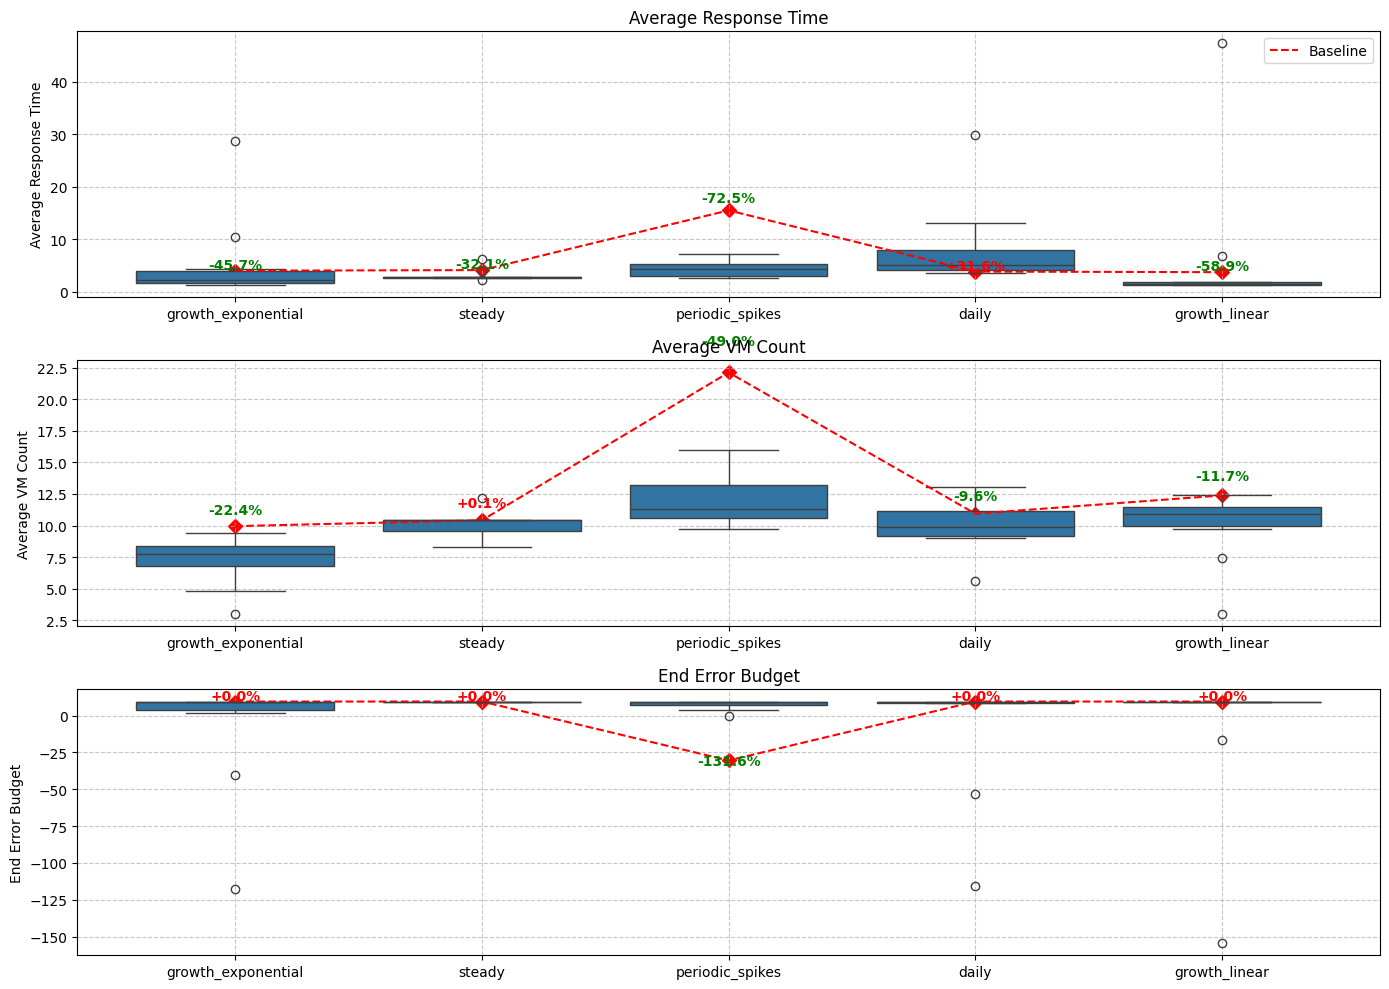

In [10]:

plot_multi_run_comparison(
    results_list=multiple_ga_results,
    baseline_results=comparison_results,
    metrics=['response_time', 'vm_count', 'error_budget'],
    figsize=(14, 10)
)

# Create comparison tables for the GA results and the baseline results
response_table, vm_table, error_table = create_metric_comparison_tables(
    multiple_ga_results, comparison_results, traffic_patterns.keys()
)

display(response_table)
display(vm_table)
display(error_table)